In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [2]:
PATH = "data"
AUTOTUNE = tf.data.experimental.AUTOTUNE
WIDTH, HEIGHT = 128, 128
BATCH_SIZE = 4

def load_data(path):
    images = sorted(glob(f"{path}/images/*.png"))
    masks = sorted(glob(f"{path}/masks/*.png"))
    return images, masks

In [3]:
image_files, mask_files = load_data(PATH)

In [4]:
print(len(image_files), len(mask_files))
DATASET_SIZE = len(image_files)

2667 2667


In [5]:
print(image_files[0], mask_files[0])
#print(images)

data/images/ds10_pexels-photo-687782.png data/masks/ds10_pexels-photo-687782.png


In [6]:
dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))


In [7]:
print(dataset)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>


In [8]:
def normalize(input_image, input_mask):
    #input_image = tf.cast(input_image, tf.float32)/ 255.0
    input_image = input_image/255.0
    input_mask -= 1
    
    return input_image, input_mask


def read_image(image_file, mask_file):
    #print(image_file, mask_file)
    img = tf.io.read_file(image_file)
    img = tf.image.decode_png(img, channels=3, dtype=tf.uint16)
    img = tf.image.resize(img, size=(WIDTH, HEIGHT))
    msk = tf.io.read_file(mask_file)
    msk = tf.image.decode_png(msk, channels=1, dtype=tf.uint16)
    msk = tf.image.resize(msk, size=(WIDTH, HEIGHT))
    
    img, msk = normalize(img, msk)
    
    return img, msk

In [9]:
dataset = dataset.map(read_image).batch(BATCH_SIZE)


In [10]:
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
print(dataset)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [12]:
def display(display_list):
    plt.figure(figsize=(128,128))
    print(display_list)
    title = ['input image', 'true mask', 'predicted mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[ 81.00736  ,  68.68195  ,  59.23342  ],
        [ 32.90352  ,  15.770186 ,   7.769447 ],
        [ 28.832779 ,  16.099901 ,  10.682744 ],
        ...,
        [ 58.913548 ,  49.56738  ,  40.49679  ],
        [ 27.038542 ,  38.96731  ,  25.7      ],
        [ 27.310186 ,  36.793163 ,  25.349617 ]],

       [[ 72.43479  ,  69.03332  ,  54.041653 ],
        [ 96.11812  ,  89.77973  ,  71.63856  ],
        [ 39.869843 ,  25.096672 ,  18.04177  ],
        ...,
        [ 58.888943 ,  52.807438 ,  40.74777  ],
        [ 26.44604  ,  40.080463 ,  25.378159 ],
        [ 20.83007  ,  30.789412 ,  18.869501 ]],

       [[101.18292  ,  98.138725 ,  81.84592  ],
        [ 94.23727  ,  87.12234  ,  74.20639  ],
        [ 66.06786  ,  52.724762 ,  44.903152 ],
        ...,
        [ 46.703293 ,  45.614742 ,  33.210598 ],
        [ 27.66057  ,  39.61001  ,  25.500202 ],
        [ 22.954021 ,  32.205708 ,  20.75527  ]],

       ...,

    

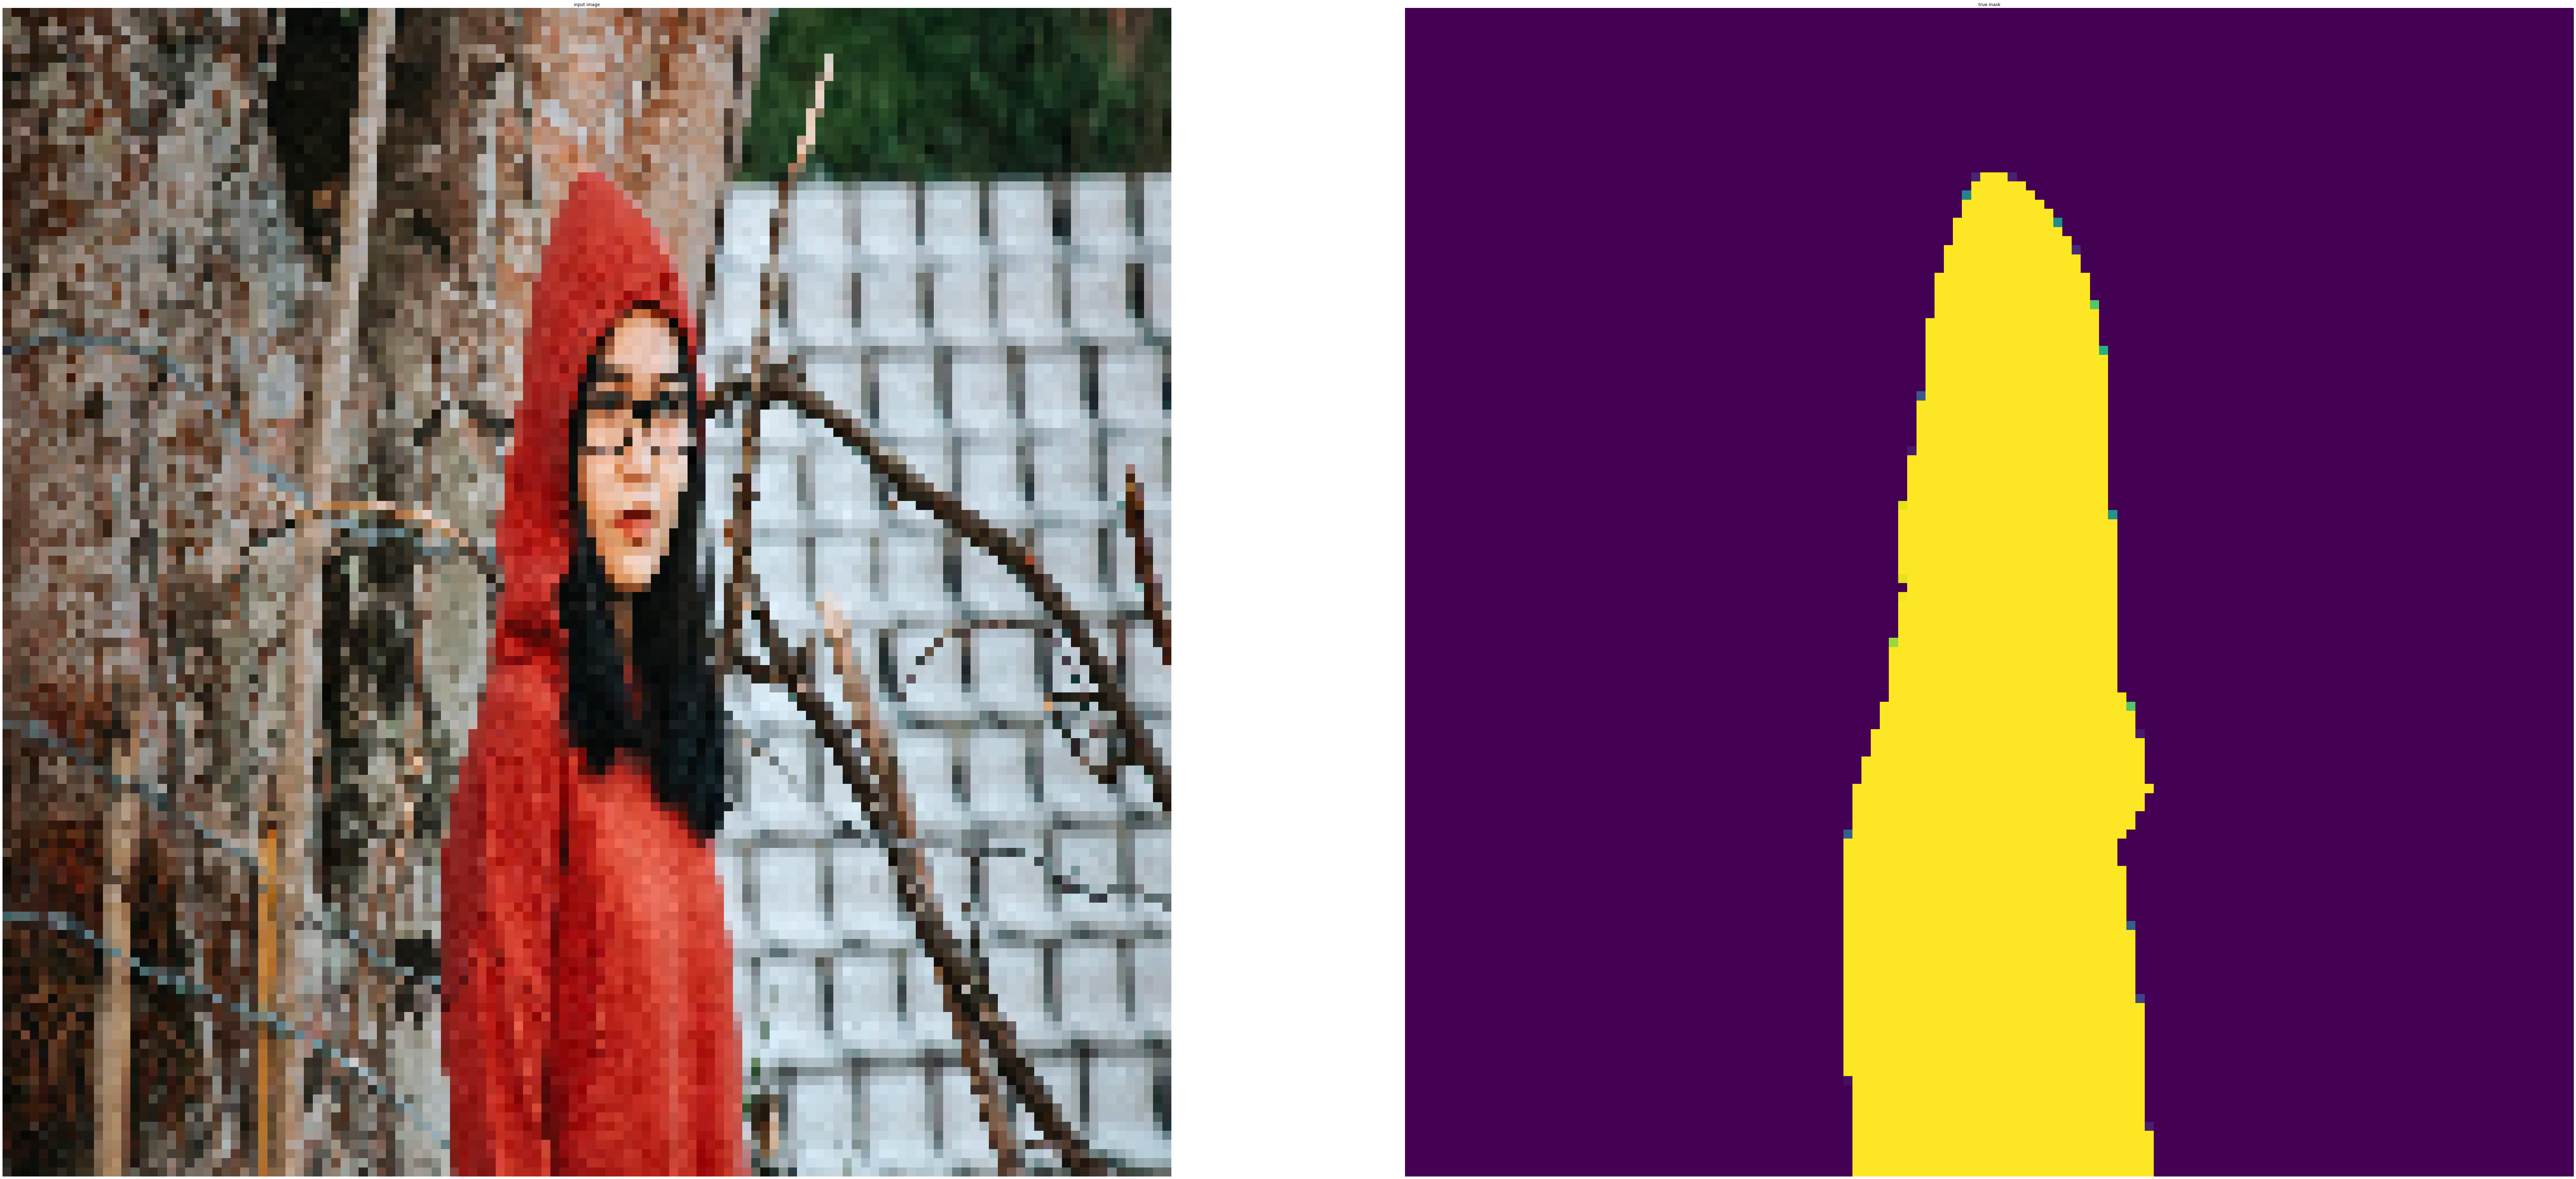

In [13]:
for image, mask in dataset.take(2):
    sample_image, sample_mask = image, mask
#display([sample_image[0], sample_mask[0]])
display([sample_image[0], sample_mask[0]])

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [16]:
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project'    
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

In [17]:
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [18]:
down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [19]:
down_stack.trainable = False

In [20]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

In [21]:
def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    skips = down_stack(inputs)
    #print(skips)

    x = skips[-1]
    #print(x)

    skips = reversed(skips[:-1])
    print(skips)

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding='same')

    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)




In [22]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[3.5904412e+00, 2.4377207e+01, 6.8139641e+01],
        [6.0470591e+00, 2.5196079e+01, 6.7525490e+01],
        [6.0470591e+00, 2.4251226e+01, 7.1131676e+01],
        ...,
        [0.0000000e+00, 5.9754074e+01, 1.1671296e+02],
        [6.5352327e-01, 5.7092739e+01, 1.1472877e+02],
        [9.3697917e-01, 5.5958916e+01, 1.1017773e+02]],

       [[6.0470591e+00, 2.5007109e+01, 6.8769547e+01],
        [4.2833333e+00, 2.5581894e+01, 6.8147522e+01],
        [5.0943322e+00, 2.3487469e+01, 7.0549019e+01],
        ...,
        [5.5116422e-02, 5.9391880e+01, 1.1757907e+02],
        [1.0078431e+00, 5.7447060e+01, 1.1489412e+02],
        [5.5903798e-01, 5.7187225e+01, 1.1425634e+02]],

       [[3.0235295e+00, 2.4188236e+01, 7.1304901e+01],
        [6.0470591e+00, 2.5196079e+01, 6.8407356e+01],
        [4.0313725e+00, 2.5188204e+01, 7.2580452e+01],
        ...,
        [1.1810662e-01, 6.0407597e+01, 1.2099629e+02],
        [1.2598039e-0

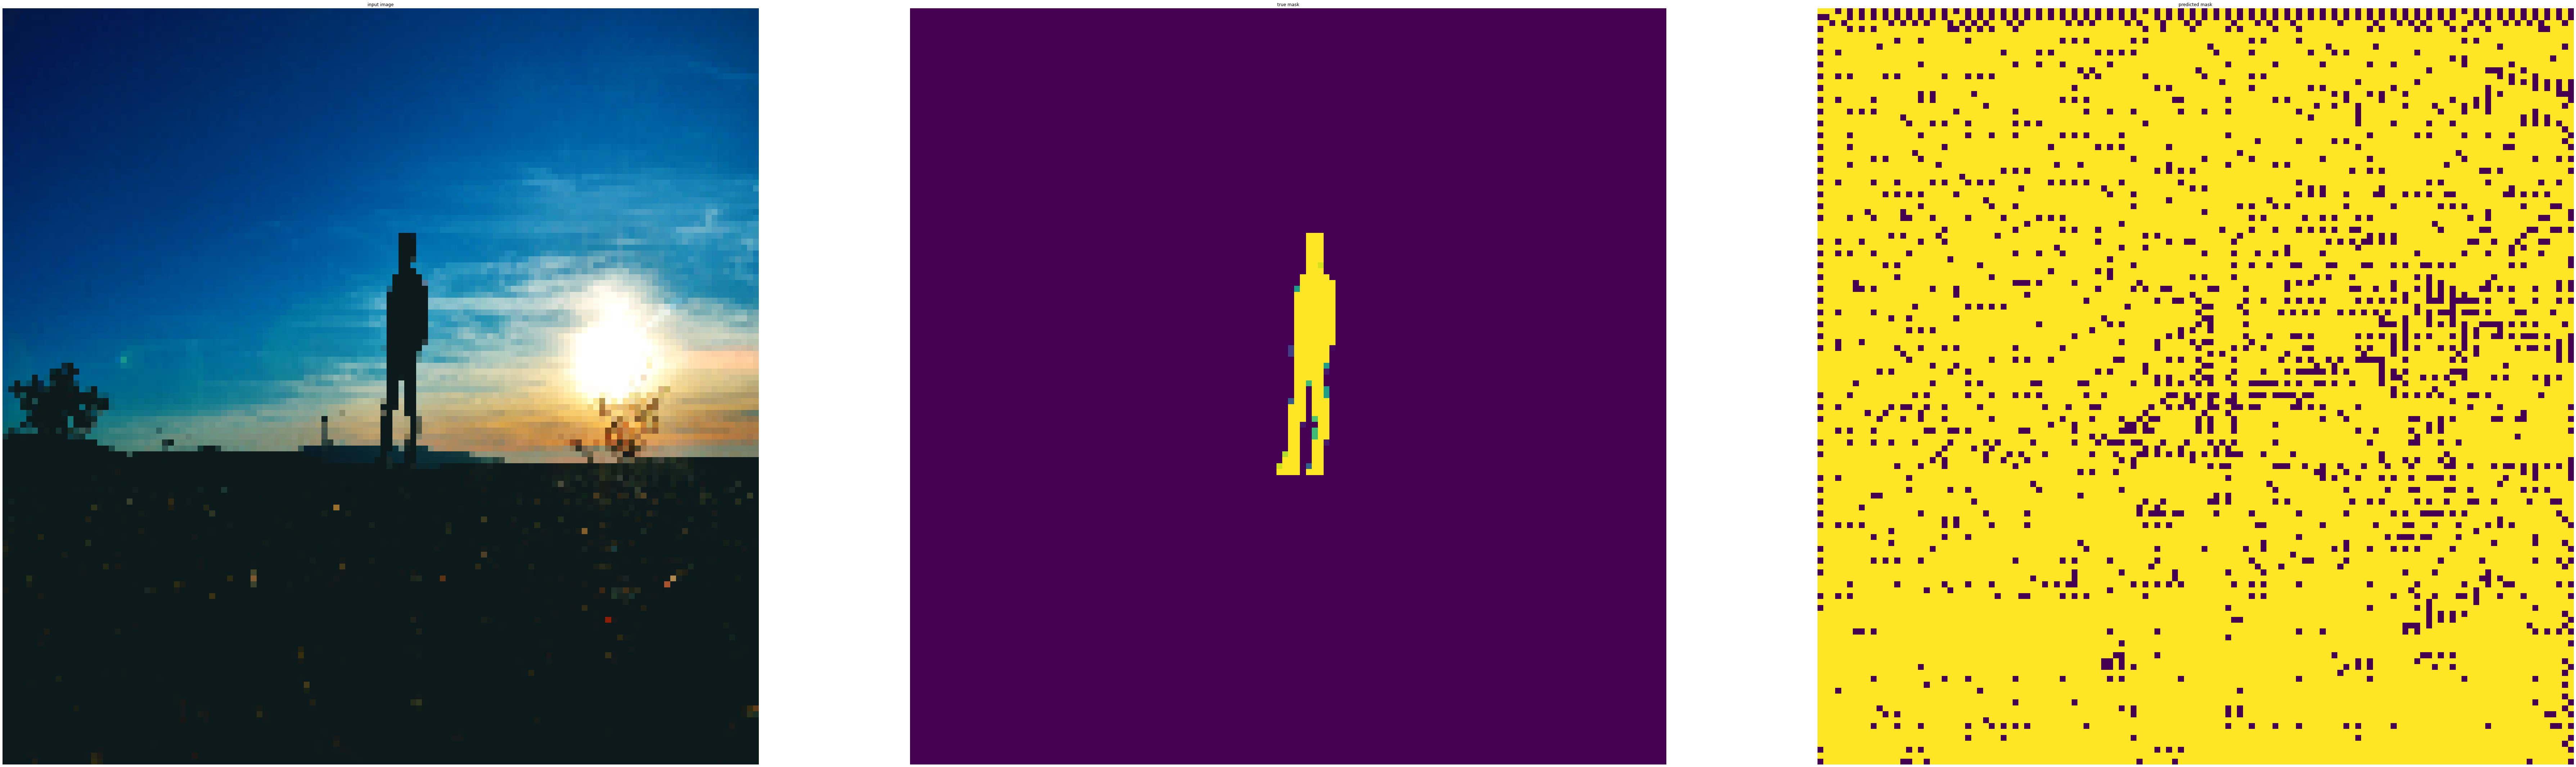

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[ 81.00736  ,  68.68195  ,  59.23342  ],
        [ 32.90352  ,  15.770186 ,   7.769447 ],
        [ 28.832779 ,  16.099901 ,  10.682744 ],
        ...,
        [ 58.913548 ,  49.56738  ,  40.49679  ],
        [ 27.038542 ,  38.96731  ,  25.7      ],
        [ 27.310186 ,  36.793163 ,  25.349617 ]],

       [[ 72.43479  ,  69.03332  ,  54.041653 ],
        [ 96.11812  ,  89.77973  ,  71.63856  ],
        [ 39.869843 ,  25.096672 ,  18.04177  ],
        ...,
        [ 58.888943 ,  52.807438 ,  40.74777  ],
        [ 26.44604  ,  40.080463 ,  25.378159 ],
        [ 20.83007  ,  30.789412 ,  18.869501 ]],

       [[101.18292  ,  98.138725 ,  81.84592  ],
        [ 94.23727  ,  87.12234  ,  74.20639  ],
        [ 66.06786  ,  52.724762 ,  44.903152 ],
        ...,
        [ 46.703293 ,  45.614742 ,  33.210598 ],
        [ 27.66057  ,  39.61001  ,  25.500202 ],
        [ 22.954021 ,  32.205708 ,  20.75527  ]],

       ...,

    

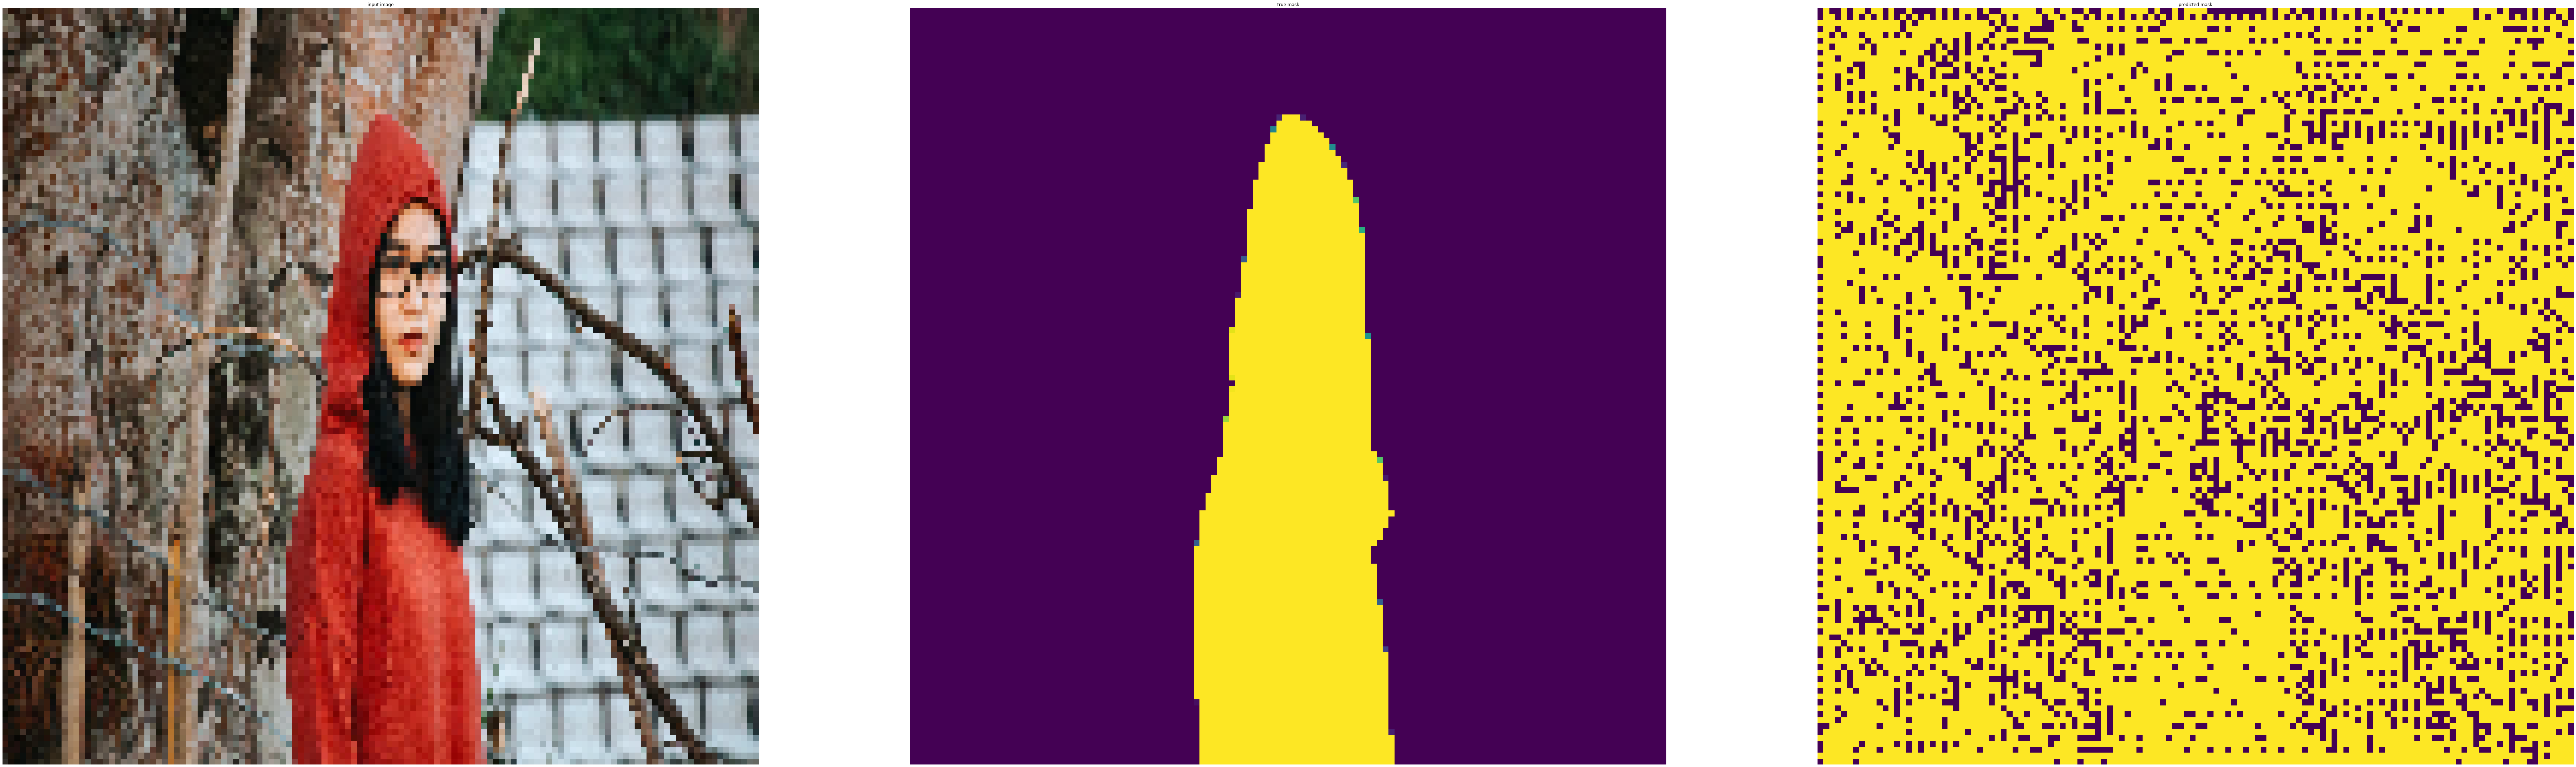

In [24]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=2):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions(dataset)

In [25]:
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

print(train_size, val_size, test_size)

2133 266 266


In [26]:
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
validation_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

In [27]:
print(train_ds, test_ds, validation_ds)

<TakeDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)> <TakeDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)> <SkipDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [28]:
print(train_ds.cardinality)

<bound method DatasetV2.cardinality of <TakeDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>>


In [29]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(dataset)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [30]:
print(train_ds)

<TakeDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[3.5904412e+00, 2.4377207e+01, 6.8139641e+01],
        [6.0470591e+00, 2.5196079e+01, 6.7525490e+01],
        [6.0470591e+00, 2.4251226e+01, 7.1131676e+01],
        ...,
        [0.0000000e+00, 5.9754074e+01, 1.1671296e+02],
        [6.5352327e-01, 5.7092739e+01, 1.1472877e+02],
        [9.3697917e-01, 5.5958916e+01, 1.1017773e+02]],

       [[6.0470591e+00, 2.5007109e+01, 6.8769547e+01],
        [4.2833333e+00, 2.5581894e+01, 6.8147522e+01],
        [5.0943322e+00, 2.3487469e+01, 7.0549019e+01],
        ...,
        [5.5116422e-02, 5.9391880e+01, 1.1757907e+02],
        [1.0078431e+00, 5.7447060e+01, 1.1489412e+02],
        [5.5903798e-01, 5.7187225e+01, 1.1425634e+02]],

       [[3.0235295e+00, 2.4188236e+01, 7.1304901e+01],
        [6.0470591e+00, 2.5196079e+01, 6.8407356e+01],
        [4.0313725e+00, 2.5188204e+01, 7.2580452e+01],
        ...,
        [1.1810662e-01, 6.0407597e+01, 1.2099629e+02],
        [1.2598039e-0

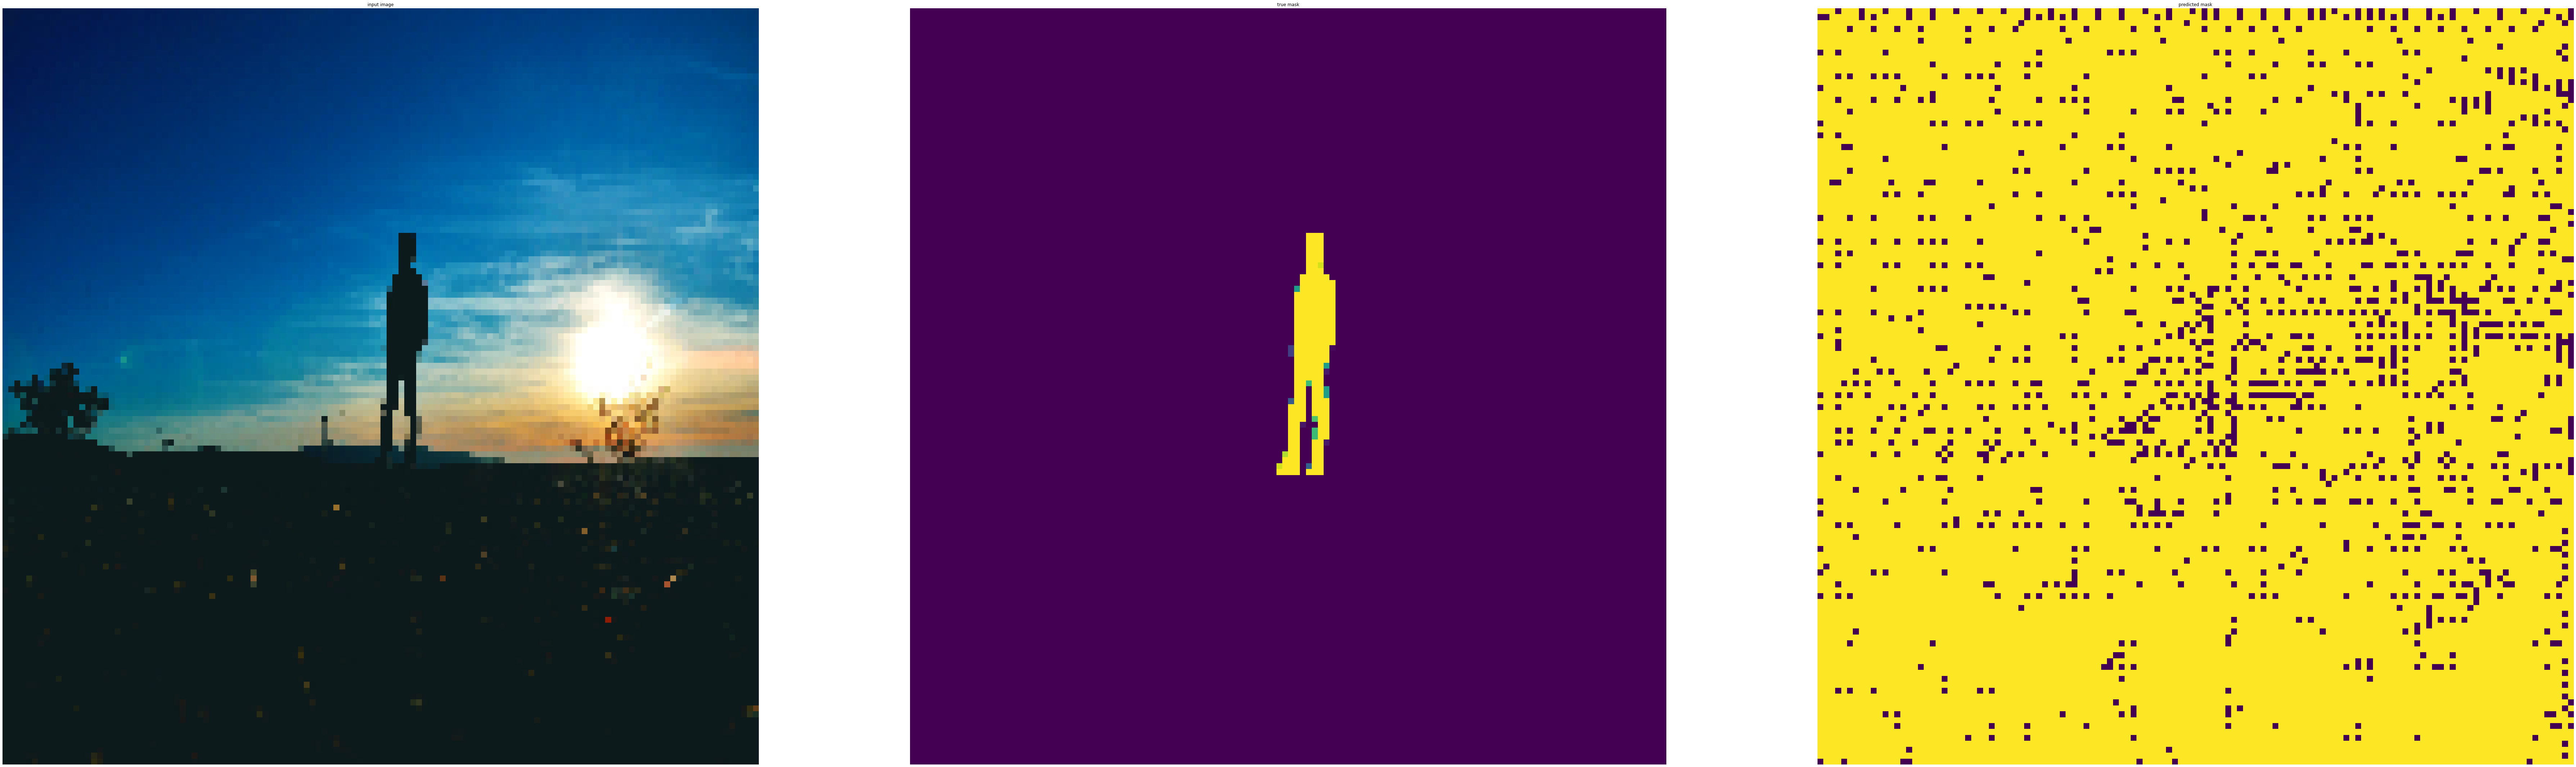

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[ 81.00736  ,  68.68195  ,  59.23342  ],
        [ 32.90352  ,  15.770186 ,   7.769447 ],
        [ 28.832779 ,  16.099901 ,  10.682744 ],
        ...,
        [ 58.913548 ,  49.56738  ,  40.49679  ],
        [ 27.038542 ,  38.96731  ,  25.7      ],
        [ 27.310186 ,  36.793163 ,  25.349617 ]],

       [[ 72.43479  ,  69.03332  ,  54.041653 ],
        [ 96.11812  ,  89.77973  ,  71.63856  ],
        [ 39.869843 ,  25.096672 ,  18.04177  ],
        ...,
        [ 58.888943 ,  52.807438 ,  40.74777  ],
        [ 26.44604  ,  40.080463 ,  25.378159 ],
        [ 20.83007  ,  30.789412 ,  18.869501 ]],

       [[101.18292  ,  98.138725 ,  81.84592  ],
        [ 94.23727  ,  87.12234  ,  74.20639  ],
        [ 66.06786  ,  52.724762 ,  44.903152 ],
        ...,
        [ 46.703293 ,  45.614742 ,  33.210598 ],
        [ 27.66057  ,  39.61001  ,  25.500202 ],
        [ 22.954021 ,  32.205708 ,  20.75527  ]],

       ...,

    

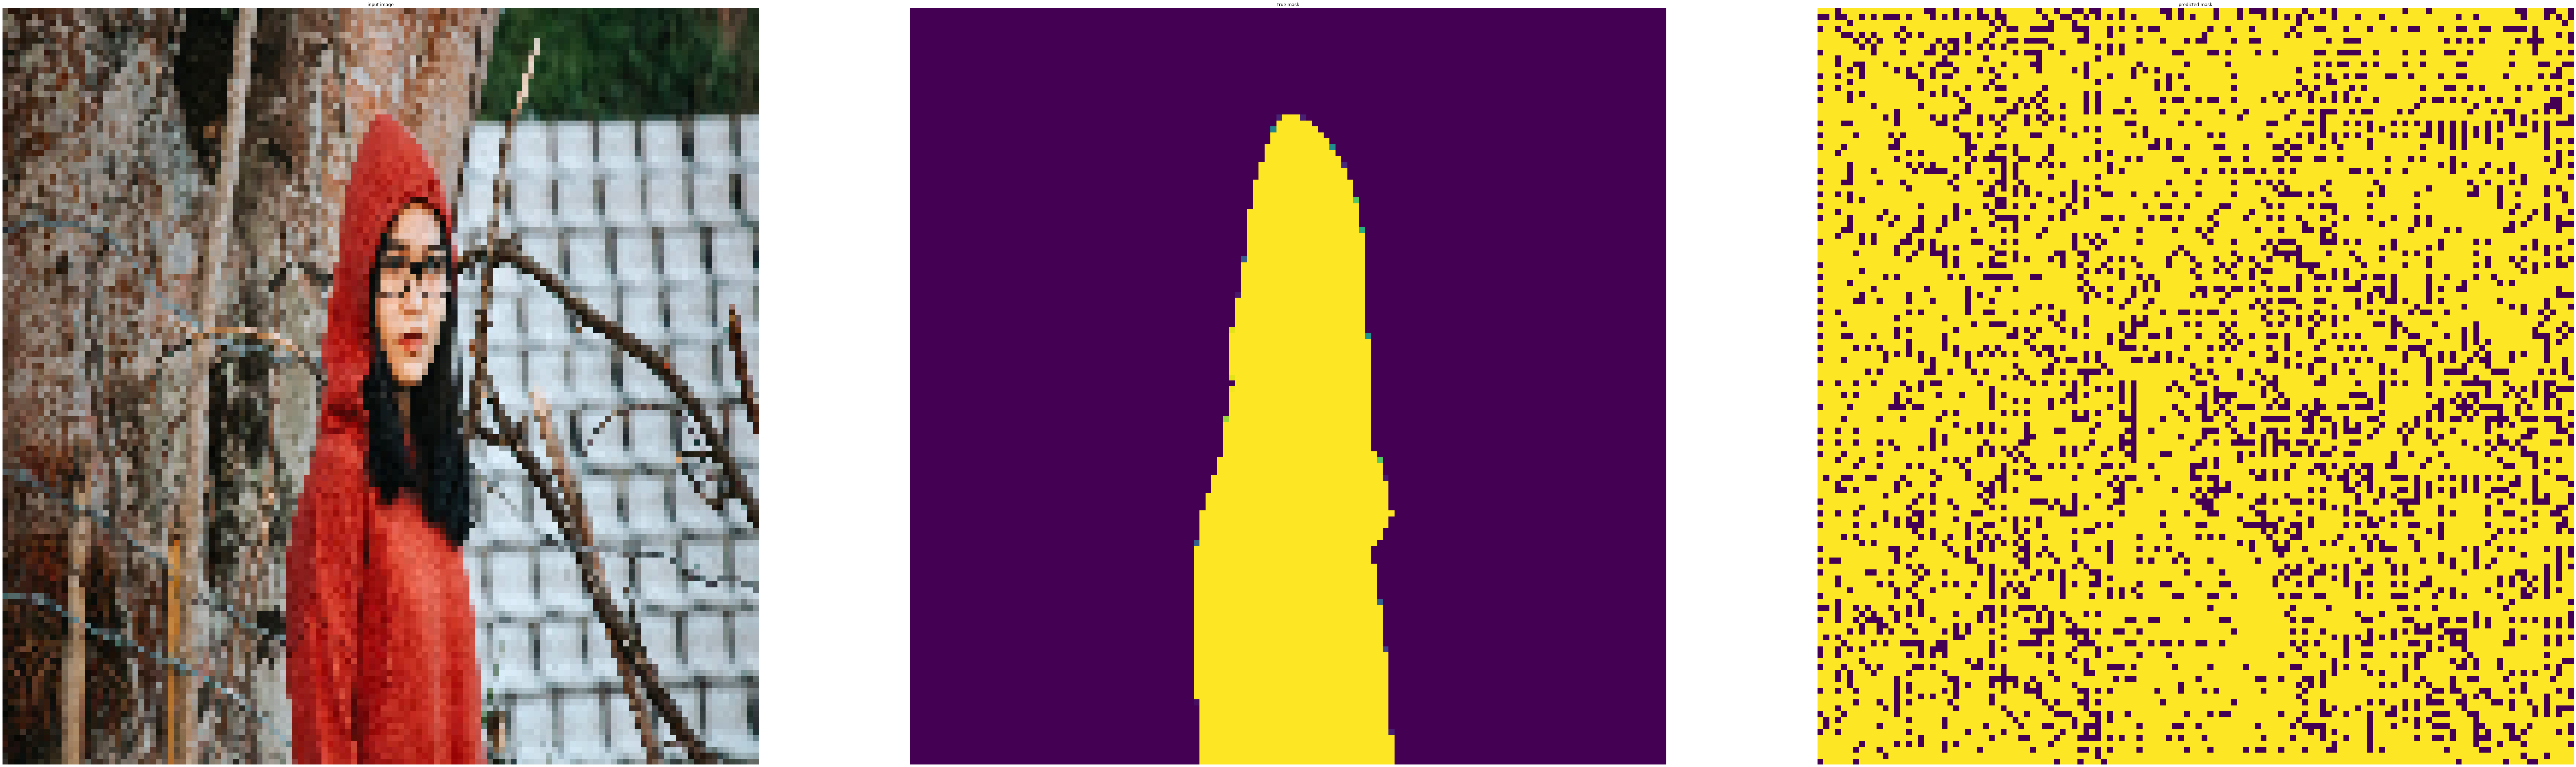


Sample Prediction after epoch 1



In [31]:
EPOCHS = 1
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = train_size//BATCH_SIZE

#model_history = model.fit(train_ds, epochs=EPOCHS,
#                          steps_per_epoch=STEPS_PER_EPOCH,
#                          validation_steps=VALIDATION_STEPS,
#                          validation_data=test_ds,
#                          callbacks=[DisplayCallback()])

model_history = model.fit(train_ds, epochs=EPOCHS,
                          validation_data=test_ds,
                          callbacks=[DisplayCallback()])